In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from vocab_store import VocabStore
try:
    from vocab_handler import extract_vocab_target
except Exception:
    def extract_vocab_target(q):
        return q.strip()

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 5)

store = VocabStore("data/vocab_data.json")
store.load()

with open("vocab_test_data.json", "r", encoding="utf-8") as f:
    test_dataset = json.load(f)

In [3]:
def _get_word(entry):
    if isinstance(entry, dict):
        for k in ("word", "term", "vocab", "vocab_target"):
            if k in entry:
                return str(entry[k])
    return None

def search_wrapper(query, top_k=5):
    if query is None or str(query).strip() == "":
        return []
    query = str(query)
    exact = store.lookup(query)
    if exact:
        return [{**e, "similarity_score": 1.0} for e in exact][:top_k]
    res = []
    try:
        res = store.search_tfidf(query, top_k=top_k, threshold=0.0)
    except Exception:
        try:
            res = store.search_tfidf(query, top_k=top_k)
        except Exception:
            pass
    if (not res) and hasattr(store, "search_substring"):
        try:
            res = store.search_substring(query)
        except Exception:
            res = []
    norm = []
    for r in res or []:
        if isinstance(r, dict):
            norm.append(r)
        elif isinstance(r, tuple) and len(r) >= 1:
            norm.append({"word": r[0], "similarity_score": r[1] if len(r) > 1 else 0})
    return norm

In [4]:
def evaluate_targets(test_dataset, top_k=5):
    rows = []
    for tc in test_dataset:
        target = str(tc.get("vocab_target", "")).strip()
        if target == "":
            continue
        expected = target.lower()
        search_q = target
        res = search_wrapper(search_q, top_k=top_k)
        found_at = None
        top_sim = res[0].get("similarity_score", 0) if res else 0
        for i, r in enumerate(res, 1):
            w = _get_word(r)
            if w and w.lower() == expected:
                found_at = i
                break
        rr = 1 / found_at if found_at else 0
        rows.append({
            "vocab_target": target,
            "search_query": search_q,
            "expected": expected,
            "query_type": "exact",
            "found_at_rank": found_at,
            "reciprocal_rank": rr,
            "top1_match": found_at == 1 if found_at else False,
            "top3_match": (found_at and found_at <= 3) or False,
            "top5_match": (found_at and found_at <= 5) or False,
            "top_similarity": top_sim,
        })
    return pd.DataFrame(rows)

results_df = evaluate_targets(test_dataset, top_k=5)
top1 = results_df.top1_match.mean() * 100
top3 = results_df.top3_match.mean() * 100
top5 = results_df.top5_match.mean() * 100
mrr = results_df.reciprocal_rank.mean()

print(f"Top-1: {top1:.1f}% | Top-3: {top3:.1f}% | Top-5: {top5:.1f}% | MRR: {mrr:.3f}")

sim_mean = results_df.top_similarity.mean()
sim_med = results_df.top_similarity.median()
print(f"Similarity mean={sim_mean:.4f}, median={sim_med:.4f}")

Top-1: 87.5% | Top-3: 87.5% | Top-5: 87.5% | MRR: 0.875
Similarity mean=0.9164, median=1.0000


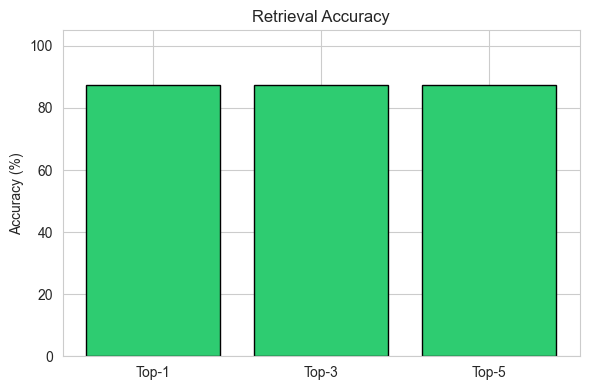

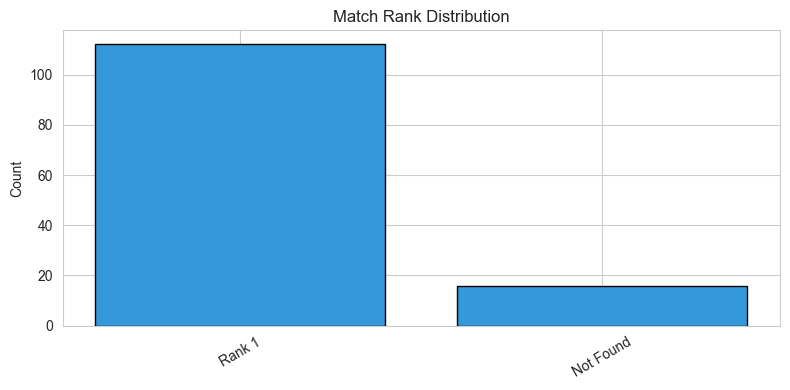

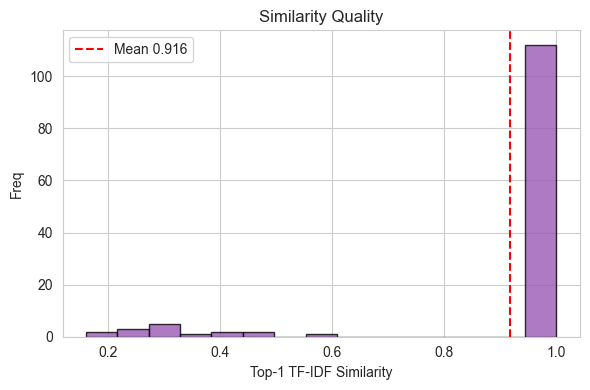


Qualitative Examples (top-3):

Q: ubiquitous
  #1: omnipresent | sim=0.3240046783713891
  #2: common_burdock | sim=0.217229353712368
  #3: fetishism | sim=0.17416123995582716

Q: serendipity
  #1: serendipity | sim=1.0
  #2: serendipity | sim=1.0


In [7]:
plt.figure(figsize=(6, 4))
plt.bar(["Top-1", "Top-3", "Top-5"], [top1, top3, top5], color="#2ecc71", edgecolor="k")
plt.ylim(0, 105); plt.ylabel("Accuracy (%)"); plt.title("Retrieval Accuracy")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8, 4))
rank_counts = results_df.found_at_rank.value_counts(dropna=False).sort_index()
labels = [f"Rank {int(r)}" if pd.notna(r) else "Not Found" for r in rank_counts.index]
plt.bar(labels, rank_counts.values, color="#3498db", edgecolor="k")
plt.title("Match Rank Distribution"); plt.ylabel("Count"); plt.xticks(rotation=30)
plt.tight_layout(); plt.show()

plt.figure(figsize=(6, 4))
plt.hist(results_df.top_similarity, bins=15, color="#9b59b6", edgecolor="k", alpha=0.8)
plt.axvline(sim_mean, color="r", linestyle="--", label=f"Mean {sim_mean:.3f}")
plt.xlabel("Top-1 TF-IDF Similarity"); plt.ylabel("Freq"); plt.title("Similarity Quality")
plt.legend()
plt.tight_layout(); plt.show()

examples = [
    {"query": "ubiquitous"},
    {"query": "serendipity"},
]
print("\nQualitative Examples (top-3):")
for ex in examples:
    res = search_wrapper(ex["query"], top_k=3)
    print(f"\nQ: {ex['query']}")
    if not res:
        print("  (no results)")
        continue
    for i, r in enumerate(res, 1):
        w = _get_word(r)
        sim = r.get("similarity_score", None)
        print(f"  #{i}: {w} | sim={sim}")

In [6]:
bad = results_df[~results_df.top1_match]
for _, row in bad.iterrows():
    q = row["vocab_target"]
    sq = row["search_query"]
    print("\nQ:", q, "| search_query:", sq, "| expected:", row["expected"])
    print("search on search_query:", search_wrapper(sq, top_k=3))
    print("search on raw:", search_wrapper(q, top_k=3))


Q: temporary | search_query: temporary | expected: temporary
search on search_query: [{'word': 'temp', 'pos': 'n', 'definition': 'a worker (especially in an office) hired on a temporary basis', 'examples': [], 'synonyms': ['temp', 'temporary', 'temporary_worker'], 'source': 'wordnet', 'similarity_score': 0.3058672941011343}, {'word': 'irregular', 'pos': 's', 'definition': 'lacking continuity or regularity', 'examples': ['an irregular worker', 'employed on a temporary basis'], 'synonyms': ['irregular', 'temporary'], 'source': 'wordnet', 'similarity_score': 0.2874296779646513}, {'word': 'pause', 'pos': 'n', 'definition': 'temporary inactivity', 'examples': [], 'synonyms': ['pause'], 'source': 'wordnet', 'similarity_score': 0.2486157378152561}]
search on raw: [{'word': 'temp', 'pos': 'n', 'definition': 'a worker (especially in an office) hired on a temporary basis', 'examples': [], 'synonyms': ['temp', 'temporary', 'temporary_worker'], 'source': 'wordnet', 'similarity_score': 0.305867294